In [124]:
import math
import random
import numpy as np
from typing import Tuple

from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import colors

import matplotlib.pyplot as plt
%matplotlib inline
class RRT:
    class Node:
        def __init__(self, x, y):
            self.x = x
            self.y = y
            self.path_x = []
            self.path_y = []
            self.parent = None
            
        def __str__(self):
            return "X: " + str(self.x) + ", Y: " + str(self.y) + "\nPath len:" + str(
                len(self.path_x)) + " Node parent: " + str(self.parent) + "\n"
    
    def __init__(self, resolution, rr, obstacle_map, rand_area,
                 max_iter=100, goal_sample_rate=50, expand_dis=1,
                 show_animation=True, step=50, 
                 export_imgs=True, out_path='../dataset', name_idx=None):
        """
        Initialize grid map for a star planning
        obstacle_map: grid map containing obstacles 
        resolution: grid resolution [m]
        rr: robot radius[m]
        """
        
        self.max_iter = max_iter
        self.goal_sample_rate = goal_sample_rate
        self.rand_area = rand_area 
        self.expand_dis = expand_dis
        self.path_resolution =1
        
        self.resolution = resolution
        self.rr = rr
        self.min_x, self.min_y = 0, 0
        self.max_x, self.max_y = 0, 0
        self.start = self.Node(0,0)
        self.end = self.Node(0,0)
        self.x_width, self.y_width = 0, 0
        self.motion = self.get_motion_model()
        
        
        self.obstacle_map = obstacle_map
        self.get_og_map_info(obstacle_map)
        
        # Efficency trackers
        self.iterations = 0
        self.path_length = 0
        
        self.show_animation = show_animation
        if self.show_animation:
            self.animation = self.plannerAnimation(out_path, export_imgs, step, name_idx)

        
     
    def set_goals(self, sx, sy, gx, gy):
        self.start = self.Node(sx,sy)
        self.end = self.Node(gx,gy)
        
        self.animation.create_figure(self.min_x,self.max_x,
                             self.min_y,self.max_y,self.resolution,
                             self.obstacle_map,self.start.x,self.start.y, self.end.x,self.end.y)
        
    def get_og_map_info(self, og_map):
        self.max_x = round(og_map.shape[0])
        self.max_y = round(og_map.shape[1])
        self.x_width = round(self.max_x - self.min_x)
        self.y_width = round(self.max_y - self.min_y)
        
    
    def planning(self):

        self.node_list = [self.start]
        
        for i in range(self.max_iter):
            rnd_node = self.get_random_node()
            nearest_ind = self.get_nearest_node_index(self.node_list, rnd_node)
            nearest_node = self.node_list[nearest_ind]
            new_node = self.steer(nearest_node, rnd_node)

            in_bounds = self.check_bounds(new_node)
            if in_bounds: 
                no_collision = self.check_collision(new_node)
                if no_collision:
                    self.node_list.append(new_node)
               

            if self.calc_dist_to_goal(self.node_list[-1].x,
                                      self.node_list[-1].y) <= self.expand_dis:
                final_node = self.steer(self.node_list[-1], self.end,
                                        self.expand_dis)
                if self.check_collision(final_node):
                    print('Found goal!')
                    if self.show_animation:
                        self.animation.plot_path(self.node_list)
                    return self.generate_final_course(len(self.node_list) - 1)
    
    @staticmethod
    def get_motion_model():
        # dx, dy, cost
        motion = [[1, 0, 1],
                  [0, 1, 1],
                  [-1, 0, 1],
                  [0, -1, 1],
                  [-1, -1, math.sqrt(2)],
                  [-1, 1, math.sqrt(2)],
                  [1, -1, math.sqrt(2)],
                  [1, 1, math.sqrt(2)]]

        return motion
    
    def check_bounds(self, node):

        if node.x < self.min_x or node.x > self.max_x-1 or \
           node.y < self.min_y or node.y > self.max_y-1:
            return False  # outside - bad
        else:
            return True  # inside - ok
        
    def check_collision(self, node):

#         if node is None:
#             return False

        for i in range(len(node.path_x)):
            x = node.path_y[i]
            y = node.path_x[i]
            if (self.obstacle_map[x][y]==1):
                return False
            
        return True  # safe
        
    @staticmethod
    def get_nearest_node_index(node_list, rnd_node):
        dlist = [(node.x - rnd_node.x)**2 + (node.y - rnd_node.y)**2
                 for node in node_list]
        minind = dlist.index(min(dlist))

        return minind
    
    @staticmethod
    def calc_distance_and_angle(from_node, to_node):
        dx = to_node.x - from_node.x
        dy = to_node.y - from_node.y
        d = math.hypot(dx, dy)
        theta = math.atan2(dy, dx)
        return d, theta

    def calc_dist_to_goal(self, x, y):
        dx = x - self.end.x
        dy = y - self.end.y
        return math.hypot(dx, dy)
    
    def get_random_node(self):
        if random.randint(0, 100) > self.goal_sample_rate:
            rnd = self.Node(
                int(random.uniform(self.rand_area[0], self.rand_area[1])),
                int(random.uniform(self.rand_area[0], self.rand_area[1])))
        else:  # goal point sampling
            rnd = self.Node(self.end.x, self.end.y)
        return rnd

    def steer(self, from_node, to_node, extend_length=float("inf")):

        new_node = self.Node(from_node.x, from_node.y)
        d, theta = self.calc_distance_and_angle(new_node, to_node)

        new_node.path_x = [new_node.x]
        new_node.path_y = [new_node.y]

        
        if extend_length > d:
            extend_length = d

        n_expand = math.floor(extend_length / self.path_resolution)
        
#         print('Dist', d, 'PATH: ')
        for _ in range(n_expand):
            
            new_node.x += self.path_resolution * math.cos(theta)
            new_node.y += self.path_resolution * math.sin(theta)
            new_node.path_x.append(math.floor(new_node.x))
            new_node.path_y.append(math.floor(new_node.y))
#             print('X: ', new_node.x, ' Y: ', new_node.y)

        d, _ = self.calc_distance_and_angle(new_node, to_node)
        if d <= self.path_resolution:
            new_node.path_x.append(to_node.x)
            new_node.path_y.append(to_node.y)
            new_node.x = to_node.x
            new_node.y = to_node.y
#             print('X: ', new_node.x, ' Y: ', new_node.y)

        new_node.parent = from_node
       
        return new_node

    def generate_final_course(self, goal_ind):
        path = [[self.end]]
        node = self.node_list[goal_ind]
        while node.parent is not None:
            path.append([node.x, node.y])
            node = node.parent
        path.append([node.x, node.y])

        return path
     
    class plannerAnimation:
        def __init__(self, out_path, export_imgs, step, name_idx=None,):
            self.fig = None
            self.ax = None
            self.pts = None
            self.x_plts,self.y_plts = [],[]
            self.txt_title = None
            self.anim = None
            self.step = step
            self.out_path = out_path
            self.export_imgs = export_imgs
            
            if name_idx is not None:
                self.name_idx = name_idx
                

        def create_figure(self, min_x,max_x,min_y,max_y,
                          resolution, obstacle_map, 
                          sx,sy,gx,gy):

            danger_color = (0.3, 0.3, 0.3, 0.6)
            safe_color = (0.9, 1, 0.9, 0.1)

            markers_color = (0.92, 0.7, 0, 1)

            font = {'family': "monospace",
                'color':  (0.92, 0.7, 0, 1),
                'weight': 'bold',
                'size': 10,
                }
        
        
            cmp=ListedColormap([safe_color, danger_color])
            with plt.style.context('ggplot'):

                self.fig = plt.figure(figsize=(10,10), dpi=120)
                self.ax = plt.subplot(1,1,1)   
                xi = np.arange(min_x, max_x, 1) * resolution # Grid in meters
                yi = np.arange(min_y, max_y, 1) * resolution # Grid in meters
                #Z = 
                #plt.pcolormesh(safe_slope, cmap='Greys')
                #plt.scatter(xi,yi, cmap='Greys')

                self.ax.imshow(obstacle_map, cmap=cmp)

                plt.xlabel("Kierunek x [m]", fontsize=10)
                plt.ylabel("Kierunek Y [m]", fontsize=10)

                locs_x = (np.arange(min_x, max_x, step=self.step)) 
                labels_x = locs_x* resolution
#                 plt.xticks(ticks=locs_x, labels=labels_x)

                locs_y = (np.arange(min_y, max_y, step=self.step)) 
                labels_y = locs_y* resolution
#                 plt.yticks(ticks=locs_y, labels=labels_y)

                self.pts, = self.ax.plot([], [], 'g.', ms=6)
                self.path, = self.ax.plot([], [], 'r-', ms=8)

                start_point = self.ax.plot(sx, sy, marker="H", markeredgecolor=markers_color,
                                    markersize=12, markerfacecolor=markers_color, label='Punkt startowy') # Start point plot 

                end_point = self.ax.plot(gx, gy, marker="X", label='Punkt końcowy', 
                                    markersize=12, markeredgecolor='b',markerfacecolor='b', linewidth=0) # End point plot )
                self.ax.grid(True)
                self.ax.axis("equal")

                self.txt_title = self.fig.suptitle('Algorytm RRT', fontsize=14)
                
                handle, label = self.ax.get_legend_handles_labels()
                add_handle = [Patch(color=danger_color)]
                add_label = ['Przeszkoda']
                handles = handle + add_handle
                labels = label + add_label

                
                self.ax.legend(handles,labels, ncol=4, bbox_to_anchor=[0.5, 1.02], loc='lower center', fontsize=8, handlelength=1.3)
                
        def plot_path(self, node_list):
            for node in node_list:
                if node.parent:
                    self.ax.plot(node.path_x, node.path_y, "-g")
                    
        def show_figure(self):
            return self.fig



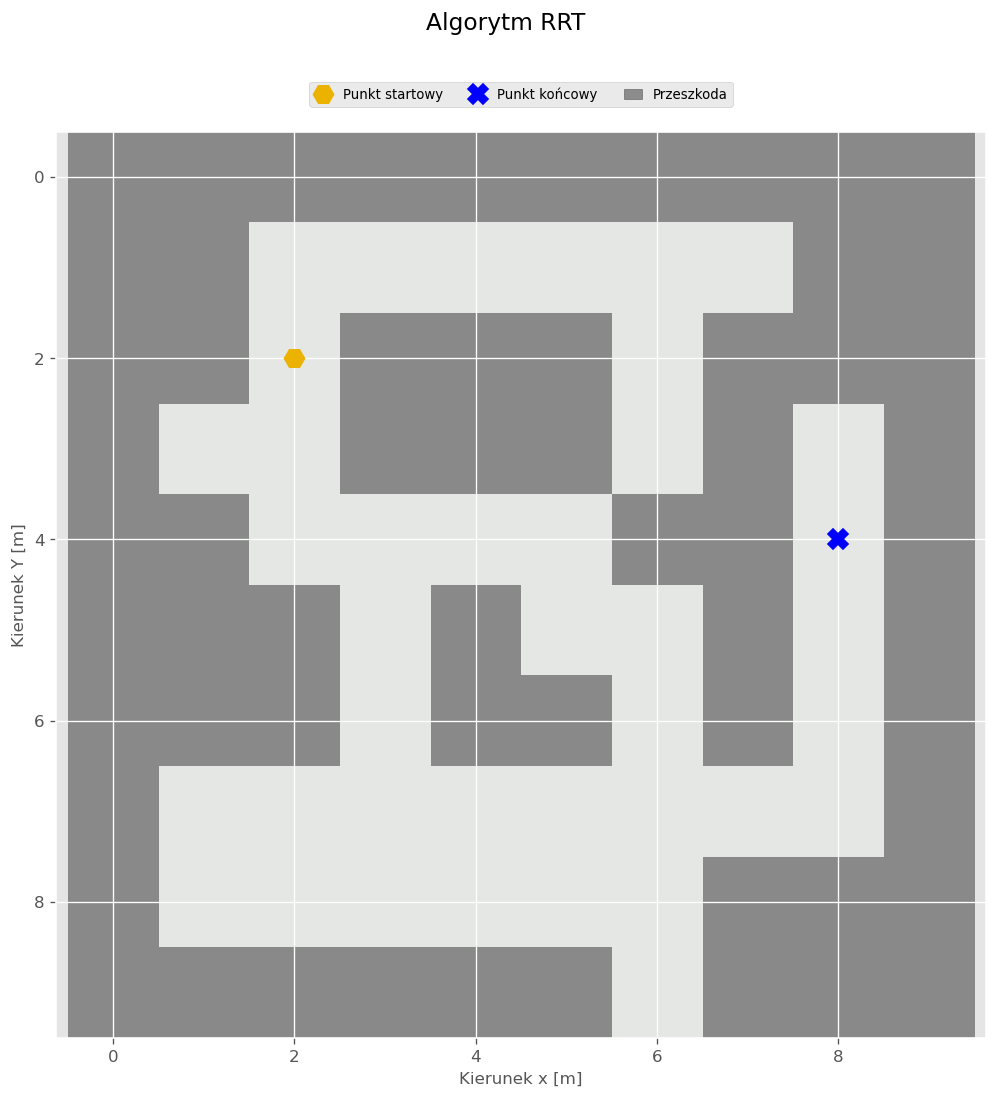

In [133]:
resolution = 1
rr = 1
obstacle_map = np.array([[1,1,1,1,1,1,1,1,1,1],
                         [1,1,0,0,0,0,0,0,1,1],
                         [1,1,0,1,1,1,0,1,1,1],
                         [1,0,0,1,1,1,0,1,0,1],
                         [1,1,0,0,0,0,1,1,0,1],
                         [1,1,1,0,1,0,0,1,0,1],
                         [1,1,1,0,1,1,0,1,0,1],
                         [1,0,0,0,0,0,0,0,0,1],
                         [1,0,0,0,0,0,0,1,1,1],
                         [1,1,1,1,1,1,0,1,1,1],])

rrt = RRT(resolution, rr, obstacle_map, [0,12], max_iter=5000,
          show_animation=True, step=1, export_imgs=False, out_path='../dataset', name_idx=None)

sx,sy=2,2
gx,gy=8,4
rrt.set_goals(sx, sy, gx, gy)


Found goal!


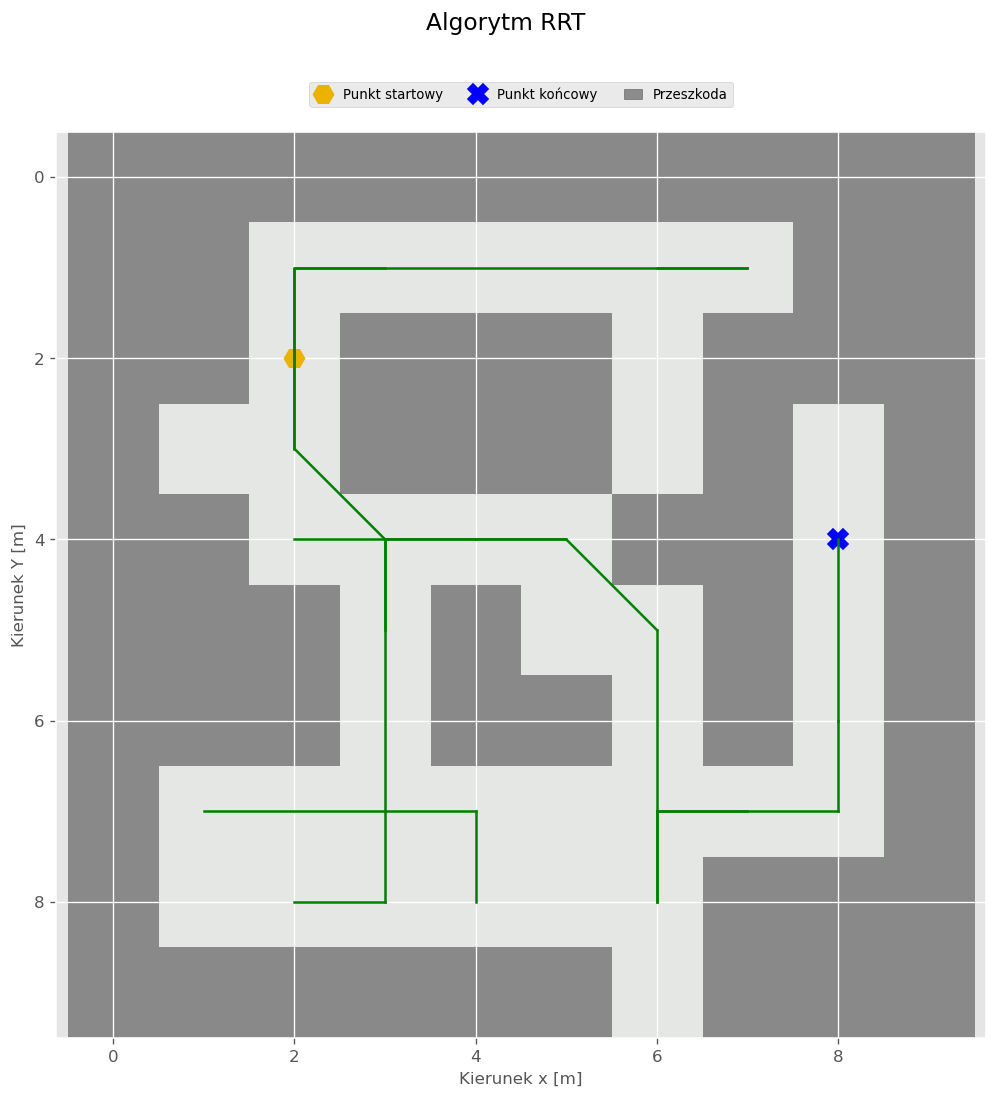

In [134]:
path = rrt.planning()
rrt.animation.show_figure()

In [ ]:
rrt.max_x

In [ ]:
import math
import random

import matplotlib.pyplot as plt
import numpy as np

from typing import Tuple
show_animation = True


class RRT:
    """
    Class for RRT planning
    """

    class Node:
        """
        RRT Node
        """

        def __init__(self, x, y):
            self.x = x
            self.y = y
            self.path_x = []
            self.path_y = []
            self.parent = None

    class AreaBounds:

        def __init__(self, area):
            self.xmin = float(area[0])
            self.xmax = float(area[1])
            self.ymin = float(area[2])
            self.ymax = float(area[3])


    def __init__(self,
                 start,
                 goal,
                 obstacle_list,
                 rand_area,
                 expand_dis=3.0,
                 path_resolution=0.5,
                 goal_sample_rate=5,
                 max_iter=500,
                 play_area=None,
                 robot_radius=0.0,
                 ):
        """
        Setting Parameter

        start:Start Position [x,y]
        goal:Goal Position [x,y]
        obstacleList:obstacle Positions [[x,y,size],...]
        randArea:Random Sampling Area [min,max]
        play_area:stay inside this area [xmin,xmax,ymin,ymax]
        robot_radius: robot body modeled as circle with given radius

        """
        self.start = self.Node(start[0], start[1])
        self.end = self.Node(goal[0], goal[1])
        self.min_rand = rand_area[0]
        self.max_rand = rand_area[1]
        if play_area is not None:
            self.play_area = self.AreaBounds(play_area)
        else:
            self.play_area = None
        self.expand_dis = expand_dis
        self.path_resolution = path_resolution
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.obstacle_list = obstacle_list
        self.node_list = []
        self.robot_radius = robot_radius

    def planning(self, animation=True):
        """
        rrt path planning

        animation: flag for animation on or off
        """

        self.node_list = [self.start]
        for i in range(self.max_iter):
            rnd_node = self.get_random_node()
            nearest_ind = self.get_nearest_node_index(self.node_list, rnd_node)
            nearest_node = self.node_list[nearest_ind]

            new_node = self.steer(nearest_node, rnd_node, self.expand_dis)

            if self.check_if_outside_play_area(new_node, self.play_area) and \
               self.check_collision(
                   new_node, self.obstacle_list, self.robot_radius):
                self.node_list.append(new_node)

            if animation and i % 5 == 0:
                self.draw_graph(rnd_node)

            if self.calc_dist_to_goal(self.node_list[-1].x,
                                      self.node_list[-1].y) <= self.expand_dis:
                final_node = self.steer(self.node_list[-1], self.end,
                                        self.expand_dis)
                if self.check_collision(
                        final_node, self.obstacle_list, self.robot_radius):
                    return self.generate_final_course(len(self.node_list) - 1)

            if animation and i % 5:
                self.draw_graph(rnd_node)

        return None  # cannot find path

    def steer(self, from_node, to_node, extend_length=float("inf")):

        new_node = self.Node(from_node.x, from_node.y)
        d, theta = self.calc_distance_and_angle(new_node, to_node)

        new_node.path_x = [new_node.x]
        new_node.path_y = [new_node.y]

        if extend_length > d:
            extend_length = d

        n_expand = math.floor(extend_length / self.path_resolution)

        for _ in range(n_expand):
            new_node.x += self.path_resolution * math.cos(theta)
            new_node.y += self.path_resolution * math.sin(theta)
            new_node.path_x.append(new_node.x)
            new_node.path_y.append(new_node.y)

        d, _ = self.calc_distance_and_angle(new_node, to_node)
        if d <= self.path_resolution:
            new_node.path_x.append(to_node.x)
            new_node.path_y.append(to_node.y)
            new_node.x = to_node.x
            new_node.y = to_node.y

        new_node.parent = from_node

        return new_node

    def generate_final_course(self, goal_ind):
        path = [[self.end.x, self.end.y]]
        node = self.node_list[goal_ind]
        while node.parent is not None:
            path.append([node.x, node.y])
            node = node.parent
        path.append([node.x, node.y])

        return path

    def calc_dist_to_goal(self, x, y):
        dx = x - self.end.x
        dy = y - self.end.y
        return math.hypot(dx, dy)

    def get_random_node(self):
        if random.randint(0, 100) > self.goal_sample_rate:
            rnd = self.Node(
                random.uniform(self.min_rand, self.max_rand),
                random.uniform(self.min_rand, self.max_rand))
        else:  # goal point sampling
            rnd = self.Node(self.end.x, self.end.y)
        return rnd

    def draw_graph(self, rnd=None):
        plt.clf()
        # for stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect(
            'key_release_event',
            lambda event: [exit(0) if event.key == 'escape' else None])
        if rnd is not None:
            plt.plot(rnd.x, rnd.y, "^k")
            if self.robot_radius > 0.0:
                self.plot_circle(rnd.x, rnd.y, self.robot_radius, '-r')
        for node in self.node_list:
            if node.parent:
                plt.plot(node.path_x, node.path_y, "-g")

        for (ox, oy, size) in self.obstacle_list:
            self.plot_circle(ox, oy, size)

        if self.play_area is not None:
            plt.plot([self.play_area.xmin, self.play_area.xmax,
                      self.play_area.xmax, self.play_area.xmin,
                      self.play_area.xmin],
                     [self.play_area.ymin, self.play_area.ymin,
                      self.play_area.ymax, self.play_area.ymax,
                      self.play_area.ymin],
                     "-k")

        plt.plot(self.start.x, self.start.y, "xr")
        plt.plot(self.end.x, self.end.y, "xr")
        plt.axis("equal")
        plt.axis([-2, 15, -2, 15])
        plt.grid(True)
        plt.pause(0.01)

    @staticmethod
    def plot_circle(x, y, size, color="-b"):  # pragma: no cover
        deg = list(range(0, 360, 5))
        deg.append(0)
        xl = [x + size * math.cos(np.deg2rad(d)) for d in deg]
        yl = [y + size * math.sin(np.deg2rad(d)) for d in deg]
        plt.plot(xl, yl, color)

    @staticmethod
    def get_nearest_node_index(node_list, rnd_node):
        dlist = [(node.x - rnd_node.x)**2 + (node.y - rnd_node.y)**2
                 for node in node_list]
        minind = dlist.index(min(dlist))

        return minind

    @staticmethod
    def check_if_outside_play_area(node, play_area):

        if play_area is None:
            return True  # no play_area was defined, every pos should be ok

        if node.x < play_area.xmin or node.x > play_area.xmax or \
           node.y < play_area.ymin or node.y > play_area.ymax:
            return False  # outside - bad
        else:
            return True  # inside - ok

    @staticmethod
    def check_collision(node, obstacleList, robot_radius):

        if node is None:
            return False

        for (ox, oy, size) in obstacleList:
            dx_list = [ox - x for x in node.path_x]
            dy_list = [oy - y for y in node.path_y]
            d_list = [dx * dx + dy * dy for (dx, dy) in zip(dx_list, dy_list)]

            if min(d_list) <= (size+robot_radius)**2:
                return False  # collision

        return True  # safe

    @staticmethod
    def calc_distance_and_angle(from_node, to_node):
        dx = to_node.x - from_node.x
        dy = to_node.y - from_node.y
        d = math.hypot(dx, dy)
        theta = math.atan2(dy, dx)
        return d, theta


In [ ]:

def main(gx=6.0, gy=10.0):
    print("start " + __file__)

    # ====Search Path with RRT====
    obstacleList = [(5, 5, 1), (3, 6, 2), (3, 8, 2), (3, 10, 2), (7, 5, 2),
                    (9, 5, 2), (8, 10, 1)]  # [x, y, radius]
    # Set Initial parameters
    rrt = RRT(
        start=[0, 0],
        goal=[gx, gy],
        rand_area=[-2, 15],
        obstacle_list=obstacleList,
        # play_area=[0, 10, 0, 14]
        robot_radius=0.8
        )
    path = rrt.planning(animation=show_animation)

    if path is None:
        print("Cannot find path")
    else:
        print("found path!!")

        # Draw final path
        if show_animation:
            rrt.draw_graph()
            plt.plot([x for (x, y) in path], [y for (x, y) in path], '-r')
            plt.grid(True)
            plt.pause(0.01)  # Need for Mac
            plt.show()


In [ ]:
obstacleList = [(5, 5, 1), (3, 6, 2), (3, 8, 2), (3, 10, 2), (7, 5, 2),
                (9, 5, 2), (8, 10, 1)]  # [x, y, radius]